# Setting up

In [1]:
# %pip install matplotlib
# %pip install tensorflow==2.14.0
# %pip install innvestigate==2.1.2

In [2]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# Reconstruct Model

## Define the architecture that was made before

In [3]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

input_shape = (256, 256, 3)
input_layer = Input(shape=input_shape)

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)
base_model.trainable=False
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

output_layer = Dense(7, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

Instructions for updating:
Colocations handled automatically by placer.


## Load the saved weight

In [4]:
model.load_weights('../src/models/res_net_model_weight.h5')

## Check classification result

### Preprocess image

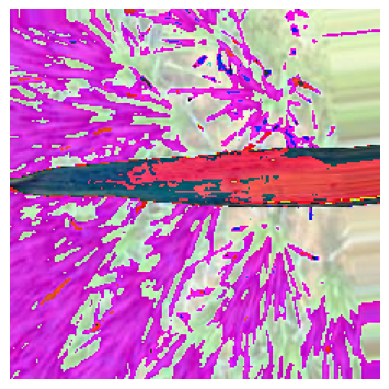

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Load an image
img_path = "../data/test/Bacterial Leaf Blight/aug_0_14.jpg"
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

plt.imshow(img_array[0].astype('uint8'))
plt.axis('off')
plt.show()

## Check original image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess_resnet(x):
    """Deprocess image that used keras.applications.resnet.preprocess_input"""
    x = x.copy()
    mean = [103.939, 116.779, 123.68]  # BGR, From ImageNet mean
    # Return values using mean
    x[..., 0] += mean[0]
    x[..., 1] += mean[1]
    x[..., 2] += mean[2]
    # Reverse BGR tp RGB
    x = x[..., ::-1]
    # Make sure that the values are in [0-255]
    return np.clip(x, 0, 255).astype("uint8")

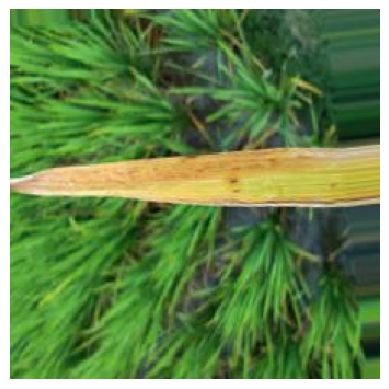

In [7]:
plt.imshow(deprocess_resnet(img_array[0]))
plt.axis("off")
plt.show()

In [8]:
y_pred = model.predict(img_array)
y_pred

c:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([[9.9999189e-01, 5.6938476e-09, 2.5528425e-12, 2.9613523e-06,
        6.6604724e-07, 4.4940980e-06, 8.7766810e-10]], dtype=float32)

In [9]:
np.argmax(y_pred,axis=1)

array([0], dtype=int64)

## Remove softmax

In [10]:
import innvestigate

model_wo_softmax = innvestigate.model_wo_softmax(model)
model_wo_softmax.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

# Create LRP analyzer

In [11]:
from innvestigate.analyzer import LRPSequentialPresetBFlat

analyzer = LRPSequentialPresetBFlat(model_wo_softmax, reverse_verbose=True)

# Get Relevance Heatmap

In [12]:
relevance = analyzer.analyze(img_array)

Reverse model: <keras.src.engine.functional.Functional object at 0x000001E8C6C33890>


c:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\innvestigate\backend\graph.py:467: UserWarning: Ignore dtype <dtype: 'float32'> as bias type.
  warnings.warn(f"Ignore dtype {dtype} as bias type.")
c:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\innvestigate\backend\graph.py:480: UserWarning: Ignore dtype <dtype: 'float32'> as bias type.
  warnings.warn(f"Ignore dtype {dtype} as bias type.")


[NID: 178] Reverse layer-node <innvestigate.layers.MaxNeuronSelection object at 0x000001E8CF5F5190>
[NID: 177] Reverse layer-node <keras.src.layers.core.dense.Dense object at 0x000001E8CF6AA810>
[NID: 176] Reverse layer-node <keras.src.layers.regularization.dropout.Dropout object at 0x000001E8D4202D90>
[NID: 175] Reverse layer-node <keras.src.layers.core.dense.Dense object at 0x000001E8D41AA510>
[NID: 174] Reverse layer-node <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000001E8D41DD950>
[NID: 173] Reverse layer-node <keras.src.layers.core.activation.Activation object at 0x000001E8CDBCFB10>
[NID: 172] Reverse layer-node <keras.src.layers.merging.add.Add object at 0x000001E8CDAE7850>
[NID: 171] Reverse layer-node <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001E8CDB53190>
[NID: 170] Reverse layer-node <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001E8CDB7B2D0>
[NID: 169] Reverse layer-node <

# LRP Visualization

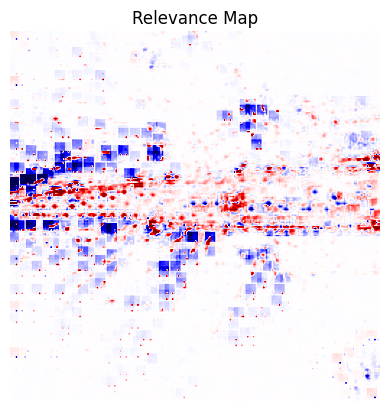

In [13]:
import numpy as np
import matplotlib.pyplot as plt

relevance_map = relevance.sum(axis=np.argmax(np.asarray(relevance.shape) == 3))[0]

# Take 99th percentile
vmax = np.percentile(np.abs(relevance_map), 99)

# Clip and normalize
relevance_map = np.clip(relevance_map, -vmax, vmax)
relevance_map /= vmax

# Plot
plt.imshow(relevance_map, cmap="seismic", clim=(-1, 1))
plt.title("Relevance Map")
plt.axis("off")
plt.show()


# Occlude Sample Image

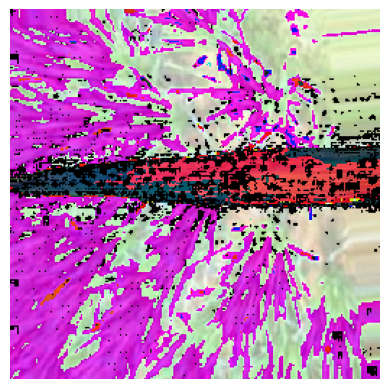

In [ ]:
import matplotlib.pyplot as plt

# Take top 10% relevant
threshold = np.percentile(relevance_map, 90)

mask = np.ones_like(img_array[0])
mask[relevance_map >= threshold, :] = 0

occluded = img_array[0] * mask
occluded = np.expand_dims(occluded, axis=0)

plt.imshow(occluded[0].astype('uint8'))
plt.axis('off')
plt.show()

## Check original image

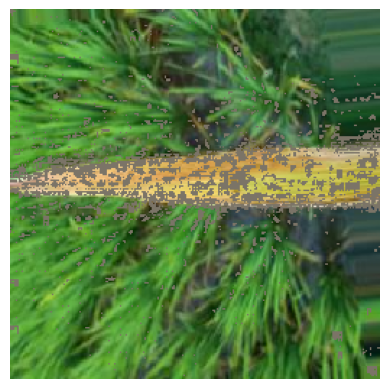

In [15]:
plt.imshow(deprocess_resnet(occluded[0]))
plt.axis("off")
plt.show()

# Occluded Image Prediction

In [16]:
occluded_y_pred = model.predict(occluded)
occluded_y_pred

array([[5.1931676e-04, 4.2549954e-04, 2.8233335e-04, 3.1781823e-03,
        9.7672451e-01, 1.7856752e-02, 1.0134755e-03]], dtype=float32)

In [17]:
np.argmax(occluded_y_pred, axis=1)

array([4], dtype=int64)

# Create Occluded LRP Analyzer

In [18]:
from innvestigate.analyzer import LRPSequentialPresetBFlat

occluded_analyzer = LRPSequentialPresetBFlat(model_wo_softmax, reverse_verbose=True)

# Get Relevance Heatmap

In [19]:
occluded_relevance = occluded_analyzer.analyze(occluded)

Reverse model: <keras.src.engine.functional.Functional object at 0x000001E950504C90>
[NID: 178] Reverse layer-node <innvestigate.layers.MaxNeuronSelection object at 0x000001E9505A5310>
[NID: 177] Reverse layer-node <keras.src.layers.core.dense.Dense object at 0x000001E8CF6AA810>
[NID: 176] Reverse layer-node <keras.src.layers.regularization.dropout.Dropout object at 0x000001E8D4202D90>
[NID: 175] Reverse layer-node <keras.src.layers.core.dense.Dense object at 0x000001E8D41AA510>
[NID: 174] Reverse layer-node <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000001E8D41DD950>
[NID: 173] Reverse layer-node <keras.src.layers.core.activation.Activation object at 0x000001E8CDBCFB10>
[NID: 172] Reverse layer-node <keras.src.layers.merging.add.Add object at 0x000001E8CDAE7850>
[NID: 171] Reverse layer-node <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001E8CDB53190>
[NID: 170] Reverse layer-node <keras.src.layers.conv

# Get Relevance Heatmap

# LRP Visualization

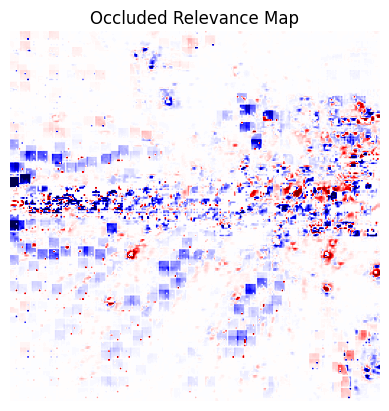

In [20]:
import numpy as np
import matplotlib.pyplot as plt

occluded_relevance_map = occluded_relevance.sum(axis=np.argmax(np.asarray(occluded_relevance.shape) == 3))[0]

# Take 99th percentile
occluded_vmax = np.percentile(np.abs(occluded_relevance_map), 99)

# Clip and normalize
occluded_relevance_map = np.clip(occluded_relevance_map, -occluded_vmax, occluded_vmax)
occluded_relevance_map /= occluded_vmax

# Plot
plt.imshow(occluded_relevance_map, cmap="seismic", clim=(-1, 1))
plt.title("Occluded Relevance Map")
plt.axis("off")
plt.show()
